# Predicting the noise level of noisy FashionMNIST images

The goal is to predict the noise level of a noisy image so it can be passed into a pretrained diffusion model.

## Imports

In [ ]:
import os
os.environ['OMP_NUM_THREADS']='1'

In [ ]:
import timm, torch, random, datasets, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F
from fastcore.foundation import L
from torch import nn
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [ ]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Load dataset

Use 28x28 images, high batch size.

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
n = 1000
sigmas = torch.linspace(0.01, 1.0, n)
xmean,xstd = 0.2859,0.353

In [ ]:
def transformi(b):
    x = (TF.to_tensor(b[xl][0])-xmean)/xstd
    sig = sigmas[random.randrange(0, n)]
    return {xl: [x.lerp(torch.randn(x.shape), sig)], yl: [sig]}

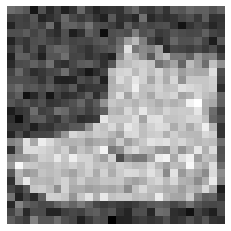

In [ ]:
tdsd = dsd.with_transform(transformi)
tds = tdsd['train']
show_image(tds[0][xl]);

In [ ]:
dls = DataLoaders.from_dd(tdsd, bs, num_workers=fc.defaults.cpus)
dl = dls.train
xb,yb = next(iter(dl))

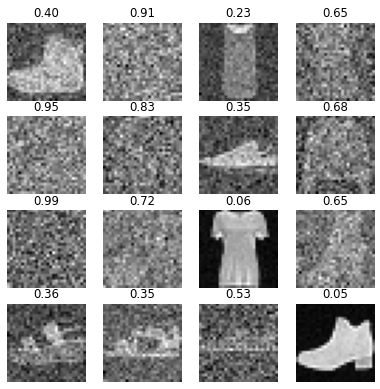

In [ ]:
titles = [f'{o:.2f}' for o in yb[:16]]
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

In [ ]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self,x): return 0.5*torch.ones((x.shape[0],))

In [ ]:
metrics = MetricsCB()

In [ ]:
lr = 1e-2
learn = TrainLearner(f(), dls, F.mse_loss, lr=lr, cbs=metrics)
learn.fit(1, train=False)

{'loss': '0.083', 'epoch': 0, 'train': 'eval'}


In [ ]:
def flat_mse(x,y): return F.mse_loss(x.flatten(), y.flatten())

In [ ]:
epochs = 4
lr = 6e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
xtra = [BatchSchedCB(sched)]
model = timm.create_model('resnet10t', in_chans=1, num_classes=1)
learn = TrainLearner(model, dls, flat_mse, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

loss,epoch,train
0.050,0,train
0.016,0,eval
0.004,1,train
0.003,1,eval
0.002,2,train
0.001,2,eval
0.001,3,train
0.001,3,eval


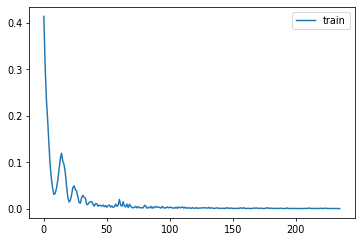

In [ ]:
learn.fit(epochs)